In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

import sys
sys.path.append("../../../")
import src

from src.core.control import AfPrecisionControl
from src.core.control import CoupledStorageConfig

from src.core.dimensionless import WavevectorScale

from src.core.media import TwoBeamPhotorefractiveCrystal
from src.core.eq_coefs import CoupledPhotorefractiveCoefs
from src.core.mesh import Mesh2D
from src.core.beams import TwoBeams

from src.fields import NotebookAfCoupledSimulation2D
from src.fields import LatticeGaussianCoupledConfig

from src.fields.landscapes.lattices.moire_lattices import double_square
from src.simulators.nls_2d.coupled_eqs.split_step import split_step_solver

from src.simulators.nls_2d.coupled_eqs import CoupledSimulationBox

In [3]:
periodic_storage = CoupledStorageConfig(directory = "./Data/Periodic/",
                                    store = "last",
                                    extension = ".h5",
                                    )

aperiodic_storage = CoupledStorageConfig(directory = "./Data/Aperiodic/",
                                    store = "last",
                                    extension = ".h5",
                                    )

In [4]:
precision = "double"

periodic_precision = AfPrecisionControl(precision=precision,
                                       store_config=periodic_storage,
                                       )

aperiodic_precision = AfPrecisionControl(precision=precision,
                                       store_config=aperiodic_storage,
                                       )

In [5]:
a = 1e9 * 1e6
b = (1e6)**2

periodic_crystal_parameters = TwoBeamPhotorefractiveCrystal(n = 2.36,
                                                   n1 = 2.36,
                                                   electro_optic_coef = 235e-12,
                                                   electro_optic_coef1 = 235e-12,
                                                   tension = 400,
                                                   Isat = .1,#b * 1e-13,
                                                   alpha = 0.,
                                                   alpha1 = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   store_config=periodic_storage,
                                                   )

aperiodic_crystal_parameters = TwoBeamPhotorefractiveCrystal(n = 2.36,
                                                   n1 = 2.36,
                                                   electro_optic_coef = 235e-12,
                                                   electro_optic_coef1 = 235e-12,
                                                   tension = 400,
                                                   Isat = .1,#b * 1e-13,
                                                   alpha = 0.,
                                                   alpha1 = 0.,
                                                   Lx = 5e-3,
                                                   Ly = 5e-3,
                                                   Lz = 20e-3,
                                                   store_config=aperiodic_storage,
                                                   )

In [6]:
periodic_crystal_parameters.Isat

0.1

In [7]:
periodic_beam_parameters = TwoBeams(wavelengths = (532e-9, 633e-9),
                             cs = (-1., -.1),
                             store_config = periodic_storage,
                             )

aperiodic_beam_parameters = TwoBeams(wavelengths = (532e-9, 633e-9),
                             cs = (-1., -.1),
                             store_config = aperiodic_storage,
                             )

In [8]:
periodic_adim_method = WavevectorScale(periodic_beam_parameters, periodic_crystal_parameters, periodic_precision)
aperiodic_adim_method = WavevectorScale(aperiodic_beam_parameters, aperiodic_crystal_parameters, aperiodic_precision)


In [9]:
solver = split_step_solver

In [10]:
periodic_coefs = CoupledPhotorefractiveCoefs(periodic_crystal_parameters,
                                    periodic_beam_parameters,
                                    periodic_adim_method,
                                    periodic_storage,
                                    )

aperiodic_coefs = CoupledPhotorefractiveCoefs(aperiodic_crystal_parameters,
                                    aperiodic_beam_parameters,
                                    aperiodic_adim_method,
                                    aperiodic_storage,
                                    )

In [11]:
simulation_config = {"Nx": 1024,
                     "Ny": 1024,
                     "Nz": 200,
                     "lx": 2e-3,
                     "ly": 2e-3,
                     "lz": 20e-3,
                     }

periodic_mesh = Mesh2D(simulation_config, periodic_adim_method)
aperiodic_mesh = Mesh2D(simulation_config, aperiodic_adim_method)

periodic_SimBox = CoupledSimulationBox(mesh=periodic_mesh,
                              coefs=periodic_coefs,
                              solver_method=solver,
                              precision_control=periodic_precision,
                              device=0,
                              gpu_backend="cuda",
                              )
aperiodic_SimBox = CoupledSimulationBox(mesh=aperiodic_mesh,
                              coefs=aperiodic_coefs,
                              solver_method=solver,
                              precision_control=aperiodic_precision,
                              device=0,
                              gpu_backend="cuda",
                              )

In [12]:
periodic_theta = np.atan(3/4)
periodic_eta = .5*(.5*np.pi - periodic_theta)

state_i = .5*1e1
lattice_i = 0.25*1e-3

periodic_modulation_properties = LatticeGaussianCoupledConfig(lattice_parameter=None,
                                                lattice1_parameter=(np.sqrt(2)*50e-6, np.sqrt(2)*50e-6),
                                                p=None,
                                                p1=(1., 1.),
                                                rotation=None,
                                                rotation1=(periodic_eta, periodic_theta+periodic_eta),
                                                width=(20e-6, 20e-6),
                                                width1=(600e-6, 600e-6),
                                                I = a * 1.5e-14 * state_i,
                                                I1 = a * 2e-6 * lattice_i,
                                                power=1.,
                                                power1=4.,
                                                store_config=periodic_storage,
                                                lattice_method=None,
                                                lattice1_method=double_square,
                                                )

aperiodic_theta = np.atan(1/np.sqrt(3))
aperiodic_eta = .5*(.5*np.pi - aperiodic_theta)
aperiodic_modulation_properties = LatticeGaussianCoupledConfig(lattice_parameter=None,
                                                lattice1_parameter=(np.sqrt(2)*50e-6, np.sqrt(2)*50e-6),
                                                p=None,
                                                p1=(1., 1.),
                                                rotation=None,
                                                rotation1=(aperiodic_eta, aperiodic_theta+aperiodic_eta),
                                                width=(20e-6, 20e-6),
                                                width1=(600e-6, 600e-6),
                                                I = a * 1.5e-13 * state_i,
                                                I1 = a * 2e-6 * lattice_i,
                                                power=1.,
                                                power1=4.,
                                                store_config=aperiodic_storage,
                                                lattice_method=None,
                                                lattice1_method=double_square,
                                                )


Lattice parameters on the first beam are not defined.
Lattice parameters on the first beam are not defined.


In [13]:
a * 1.5e-14 * state_i, a * 2e-6 * lattice_i

(75.0, 500000.0)

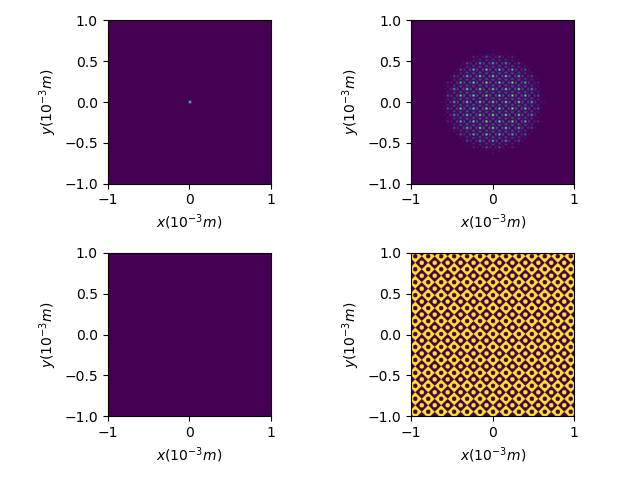

In [14]:
periodic_input_fields = NotebookAfCoupledSimulation2D(simulation_config,
                           modulation_config=periodic_modulation_properties,
                           precision_control=periodic_precision,
                           store_config=periodic_storage,
                           )

periodic_input_fields.gen_fields(periodic_mesh,)

periodic_input_fields.plot_fields()

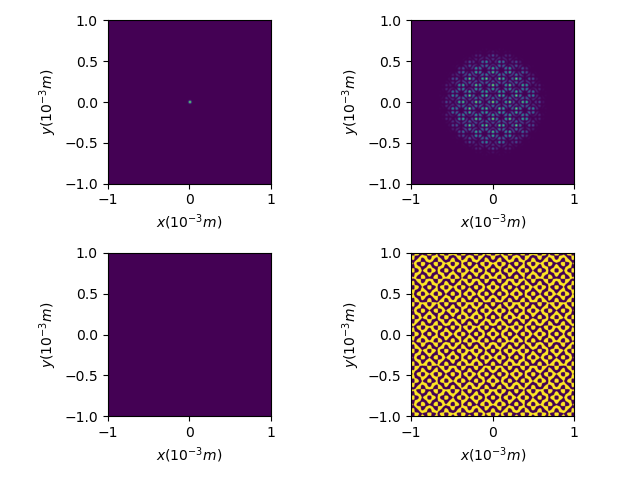

In [15]:
aperiodic_input_fields = NotebookAfCoupledSimulation2D(simulation_config,
                           modulation_config=aperiodic_modulation_properties,
                           precision_control=aperiodic_precision,
                           store_config=aperiodic_storage,
                           )

aperiodic_input_fields.gen_fields(aperiodic_mesh,)

aperiodic_input_fields.plot_fields()

In [16]:
print(f"State is between [{np.min(np.abs(periodic_input_fields.field)**2)}, {np.max(np.abs(periodic_input_fields.field)**2)}]")

print(f"Periodic Lattice is between [{np.min(np.abs(periodic_input_fields.field1)**2)}, {np.max(np.abs(periodic_input_fields.field1)**2)}]")

print(f"Aperiodic Lattice is between [{np.min(np.abs(aperiodic_input_fields.field1)**2)}, {np.max(np.abs(aperiodic_input_fields.field1)**2)}]")

area_cm2 = simulation_config["lx"]*10**2*simulation_config["ly"]*10**2

print(f"Periodic Average Intensity {np.sum(np.abs(periodic_input_fields.field1)*periodic_mesh.dx*periodic_mesh.dy)/area_cm2}; Aperiodic Average Intensity {np.sum(np.abs(aperiodic_input_fields.field1)*aperiodic_mesh.dx*aperiodic_mesh.dy)/area_cm2}")

area_state = np.pi*(20e-4)**2

print(f"Input Excitation Density {np.sum(np.abs(periodic_input_fields.field)*periodic_mesh.dx*periodic_mesh.dy)/(area_state)}")

State is between [0.0, 2.9068271056908492]
Periodic Lattice is between [0.0, 86.94468199061063]
Aperiodic Lattice is between [0.0, 86.30108590546382]
Periodic Average Intensity 2860122.897006712; Aperiodic Average Intensity 2783685.3962002434
Input Excitation Density 6967819.090687334


In [17]:
np.max(np.abs(periodic_input_fields.field)**2), np.max(np.abs(periodic_input_fields.field1)**2)

(np.float64(2.9068271056908492), np.float64(86.94468199061063))

In [18]:
periodic_SimBox.solver(periodic_input_fields, store_config=periodic_storage)

aperiodic_SimBox.solver(aperiodic_input_fields, store_config=aperiodic_storage)

e:\Vicente Rocha\PhD Thesis Project\Photonic-Crystals\Studies\PhotorefractiveCrystals\Localization in Moire Lattices\../../..\src\fields\field.py:613: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


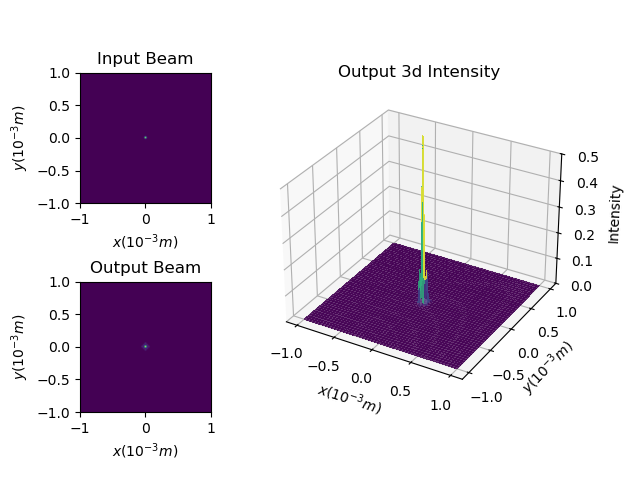

In [19]:
periodic_input_fields.plot_input_output_3d()

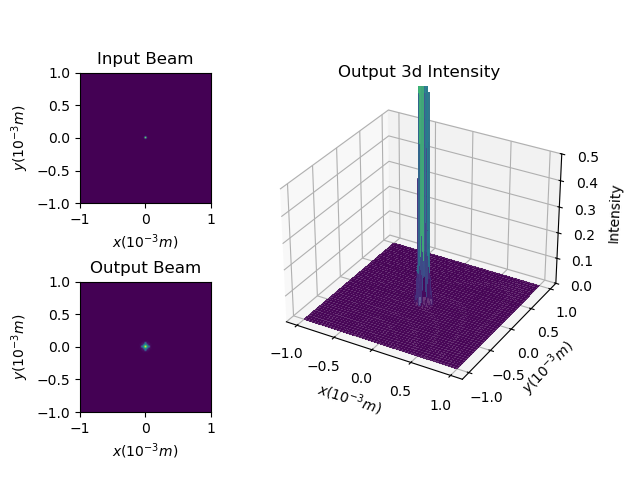

In [20]:
aperiodic_input_fields.plot_input_output_3d()

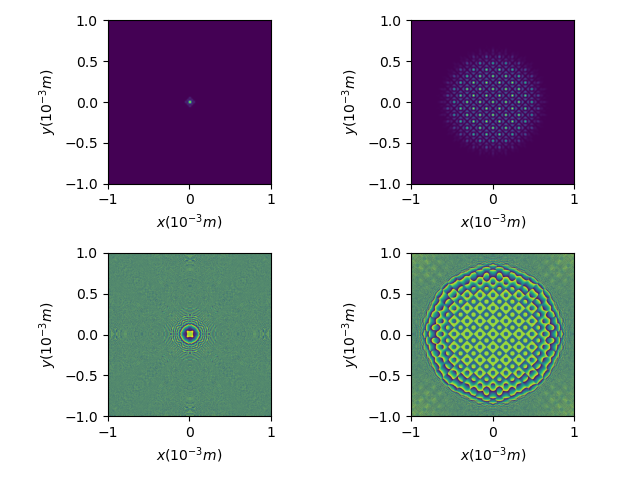

In [21]:
periodic_input_fields.plot_fields()

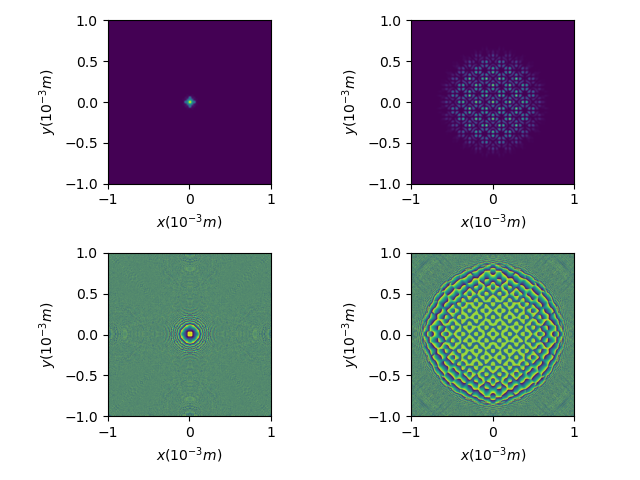

In [22]:
aperiodic_input_fields.plot_fields()